In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = Path.cwd().parent / "data"
data_path

PosixPath('/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/data')

In [3]:
df = pd.read_parquet(data_path / "processed" / "listings_regular_license.parquet", engine="pyarrow")
df.shape

(4451, 42)

Create host type categories column

In [4]:
df['host_category'] = df['host_total_listings_count'].apply(
    lambda x: 'Individual (1)' if x == 1 
    else 'Small Multi (2-3)' if x <= 3 
    else 'Large Multi (4+)'
)

In [5]:
df["host_category"].value_counts(normalize=True).round(2)

host_category
Large Multi (4+)     0.58
Individual (1)       0.24
Small Multi (2-3)    0.18
Name: proportion, dtype: float64

In [6]:
df["host_category"].value_counts()

host_category
Large Multi (4+)     2580
Individual (1)       1078
Small Multi (2-3)     793
Name: count, dtype: int64

for every category we will check average revenue, average occupancy rate, reviews per month, review ratings, response rate, acceptances rate, superhost percentage, availability 365

### 1 - Estimated revenue

In [7]:
df.sort_values(by="price", ascending=False).head(10)

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
3396,1247759047568724490,Miltos's House Thessaloniki,568348492,2024-03-22,"Athens, Greece",0.99,False,1442,True,NaN,...,4.40,4.60,4.60,5.00,4.20,4.40,00002876636,True,0.87,Large Multi (4+)
596,32565194,citizen9 urban rooms / live like a citizen,101193924,2016-10-25,None,0.75,False,5,True,"Thessaloniki, Greece",...,4.67,5.00,5.00,4.78,4.56,4.67,00000538922,False,0.17,Large Multi (4+)
3380,1242610104702164856,Μονοκατοικία με Θέα,63261419,2016-03-16,"Panorama, Greece",NaN,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00002908184,False,NaN,Individual (1)
3661,1299302723989370186,palama Urban Vibes Premium 1-Bedroom apartment,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003175340,True,NaN,Large Multi (4+)
3659,1299298635012554304,palama Urban Vibes Deluxe 1bedroom +Balcony,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003171444,True,NaN,Large Multi (4+)
597,32569288,The City Block 4,241226463,2019-02-05,"Thessaloniki, Greece",1.00,False,7,True,"Thessaloniki, Greece",...,4.79,4.79,5.00,5.00,4.84,4.53,00000598370,False,0.25,Large Multi (4+)
2554,1056625308216830035,"Mavili #2, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.42,4.36,4.55,4.61,4.12,4.27,00002334179,True,1.86,Large Multi (4+)
1855,834659957824606179,"Horizon #5, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.75,4.50,4.83,4.83,4.17,4.42,00002393158,True,0.46,Large Multi (4+)
2553,1056616089057596665,"Mavili #1, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.66,4.52,4.86,4.97,4.59,4.41,00002247165,True,1.63,Large Multi (4+)
759,37339723,The City Block 6,241226463,2019-02-05,"Thessaloniki, Greece",1.00,False,7,True,"Thessaloniki, Greece",...,5.00,5.00,5.00,5.00,5.00,4.67,00000834466,True,0.04,Large Multi (4+)


top 2 listings by price seem a lot like systematic arrors so they will be removed as they seems to affect the estimated revenue

In [8]:
indices_to_remove = df.sort_values(by="price", ascending=False).head(2).index
df.drop(indices_to_remove, inplace=True)
df.shape

(4449, 43)

In [9]:
df["price"].describe().round(2)

count    4173.00
mean       67.38
std        64.79
min        10.00
25%        44.00
50%        55.00
75%        74.00
max      2055.00
Name: price, dtype: float64

In [10]:
df["price"].isnull().sum()

np.int64(276)

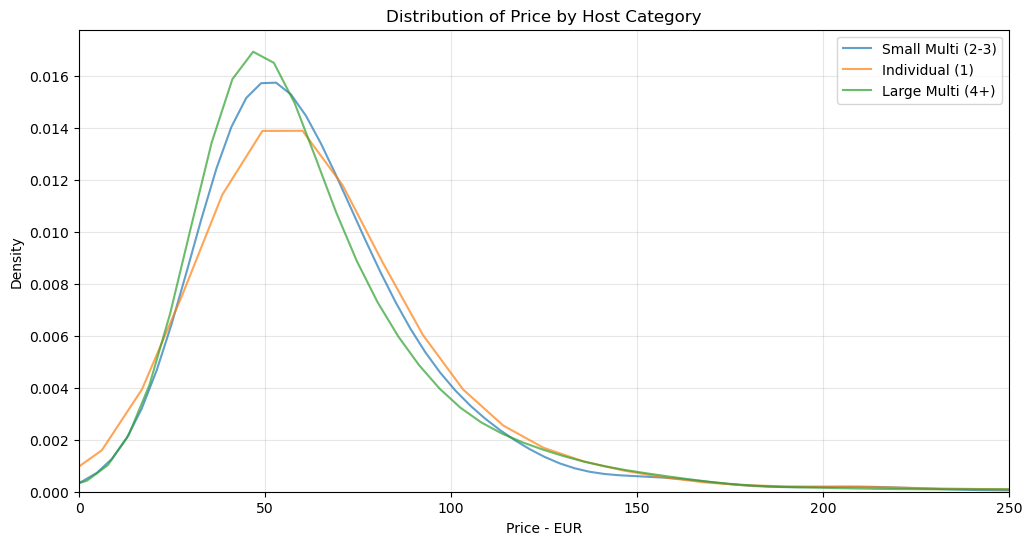

In [13]:
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['price'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Price - EUR')
plt.ylabel('Density')
plt.title('Distribution of Price by Host Category')
plt.xlim(0, 250)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Document the price distribution in your technical notebook with a note that "pricing strategies are consistent across host types, confirming revenue differences reflect operational performance rather than pricing positioning.

In [10]:
df["estimated_revenue_l365d"].describe()

count      4173.000000
mean       3998.912054
std        5747.099720
min           0.000000
25%         468.000000
50%        1980.000000
75%        5712.000000
max      109896.000000
Name: estimated_revenue_l365d, dtype: float64

In [11]:
df["estimated_revenue_l365d"].isnull().sum()    

np.int64(276)

In [46]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["estimated_revenue_l365d"].mean()
    print(f"  Average Estimated Revenue (last 365 days): {mean:.2f} EUR")


Host Category: Small Multi (2-3)
  Average Estimated Revenue (last 365 days): 3971.27 EUR
Host Category: Individual (1)
  Average Estimated Revenue (last 365 days): 4010.12 EUR
Host Category: Large Multi (4+)
  Average Estimated Revenue (last 365 days): 4002.81 EUR


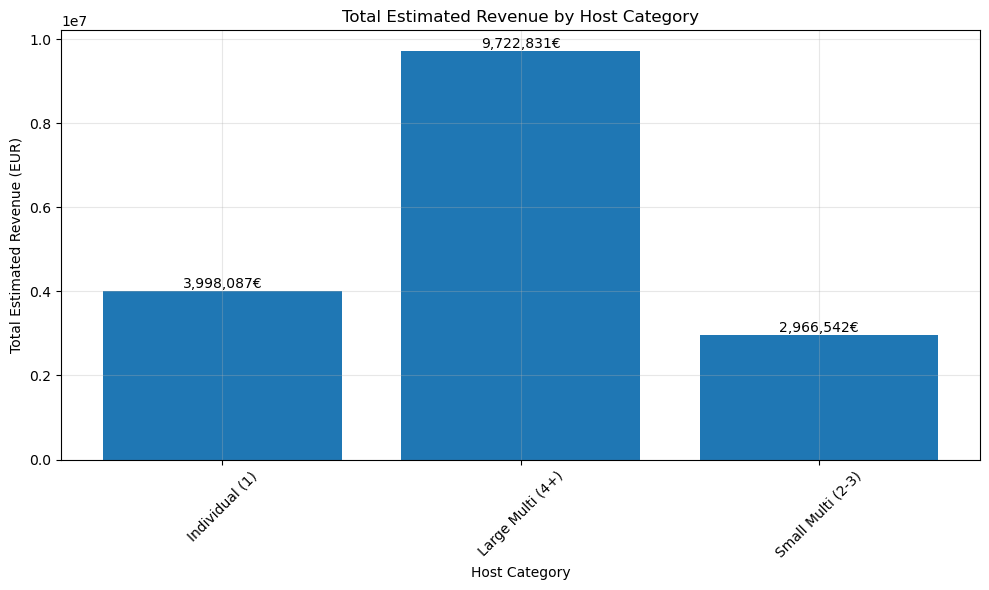

In [12]:
# Create barplot for total estimated revenue by host category
revenue_by_category = df.groupby('host_category')['estimated_revenue_l365d'].sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_by_category.index, revenue_by_category.values)
plt.xlabel('Host Category')
plt.ylabel('Total Estimated Revenue (EUR)')
plt.title('Total Estimated Revenue by Host Category')
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}€',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

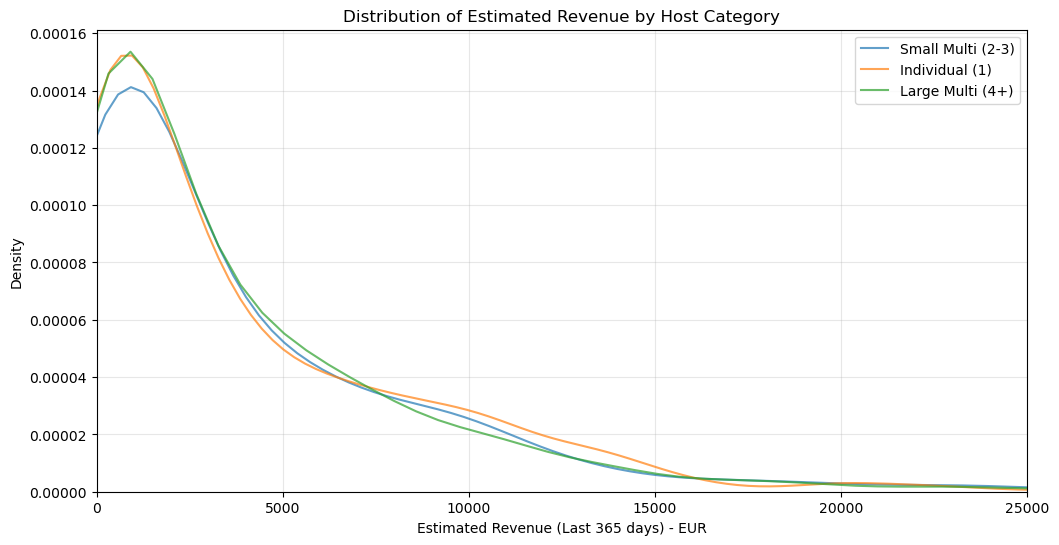

In [ ]:


# Create density plot for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_revenue_l365d'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Estimated Revenue (Last 365 days) - EUR')
plt.ylabel('Density')
plt.title('Distribution of Estimated Revenue by Host Category')
plt.xlim(0, 25000)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


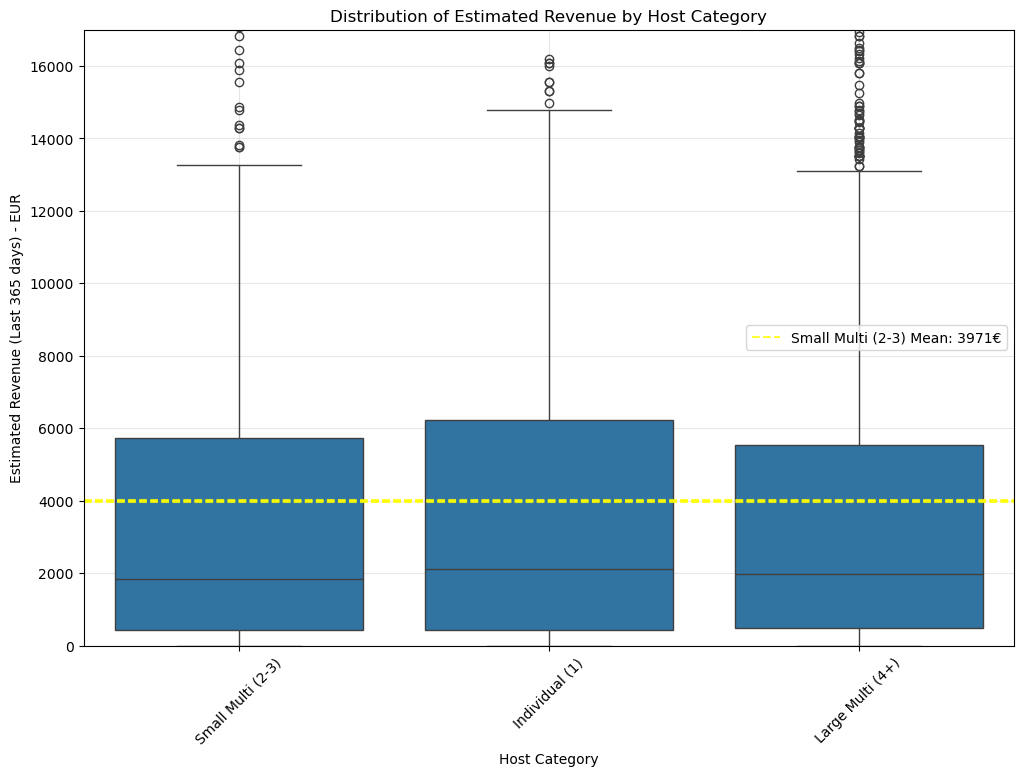

In [48]:

# Create boxplots for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='estimated_revenue_l365d')
plt.xlabel('Host Category')
plt.ylabel('Estimated Revenue (Last 365 days) - EUR')
plt.title('Distribution of Estimated Revenue by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['estimated_revenue_l365d'].mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f}€' if i == 0 else "")
plt.ylim(0, 17000)
plt.legend()
plt.show()

**comments:**
* Average estimated revenue seems to be a little larger for individual hosts followed closely by multi hosts.
* Individuals and multi hosts show similar distribution until 3000 euros, then 4+ shows bigger density in the 3000 to 7000 range and lastly the indiual listing hosts show bigger density in the 7000 to 15000 range
* 2-3 category isalways below each of those two although close 

In [38]:
df.iloc[df["estimated_revenue_l365d"].sort_values(ascending=False)[:10].index]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
3396,1247759047568724490,Miltos's House Thessaloniki,568348492,2024-03-22,"Athens, Greece",0.99,False,1442,True,NaN,...,4.40,4.60,4.60,5.00,4.20,4.40,00002876636,True,0.87,Large Multi (4+)
2553,1056616089057596665,"Mavili #1, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.66,4.52,4.86,4.97,4.59,4.41,00002247165,True,1.63,Large Multi (4+)
2554,1056625308216830035,"Mavili #2, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.42,4.36,4.55,4.61,4.12,4.27,00002334179,True,1.86,Large Multi (4+)
2277,973654859310058277,Houseloft Seaside Getaway,29565272,2015-03-18,"Thessaloniki, Greece",1.00,False,33,True,"Thessaloniki, Greece",...,4.56,4.43,4.26,4.71,4.69,4.41,00002338214,True,3.17,Large Multi (4+)
24,5170079,"""The House of Art"" - 2' from Metro Station",26719518,2015-01-26,"Thessaloniki, Greece",1.00,False,2,True,"Thessaloniki, Greece",...,4.85,4.91,4.92,4.92,4.60,4.80,00000034826,False,3.67,Small Multi (2-3)
3141,1190202611543037279,Luxurious Penthouse with Jacuzzi - Town Centre,358984136,2020-07-28,"Thessaloniki, Greece",1.00,True,3,True,NaN,...,4.98,4.96,5.00,5.00,4.80,4.94,00003001398,True,4.13,Small Multi (2-3)
2886,1135396607066567316,Luxury Sea View Retreat,549616215,2023-12-05,None,1.00,True,1,True,NaN,...,4.95,4.98,5.00,4.98,4.98,4.86,00002582880,False,3.13,Individual (1)
3927,1339075280478129205,Villa 8 Family Suite - 2 bedrooms and big balcony,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,4.90,4.80,5.00,5.00,4.70,4.80,00003185929,True,2.27,Large Multi (4+)
3433,1259390983631188736,Maisonette Casa del Mare,654928860,2024-10-01,None,1.00,True,2,True,NaN,...,5.00,5.00,5.00,5.00,5.00,4.93,00002880060,True,3.16,Small Multi (2-3)
2096,910539406178653810,Iconic Salonica Suite seafront,468818538,2022-07-11,None,1.00,True,4,True,"Thessaloniki, Greece",...,4.88,5.00,5.00,5.00,5.00,4.94,00003179901,True,1.44,Large Multi (4+)


### 2 - Occupancy rate

In [54]:
df["estimated_occupancy_l365d"].describe()

count    4449.000000
mean       65.798157
std        75.536473
min         0.000000
25%         6.000000
50%        36.000000
75%       102.000000
max       255.000000
Name: estimated_occupancy_l365d, dtype: float64

In [66]:
df["estimated_occupancy_l365d"].isnull().sum()

np.int64(0)

In [56]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["estimated_occupancy_l365d"].mean()
    print(f"  Average Estimated Occupancy (last 365 days): {mean:.2f} days")


Host Category: Small Multi (2-3)
  Average Estimated Occupancy (last 365 days): 64.87 days
Host Category: Individual (1)
  Average Estimated Occupancy (last 365 days): 66.53 days
Host Category: Large Multi (4+)
  Average Estimated Occupancy (last 365 days): 65.78 days


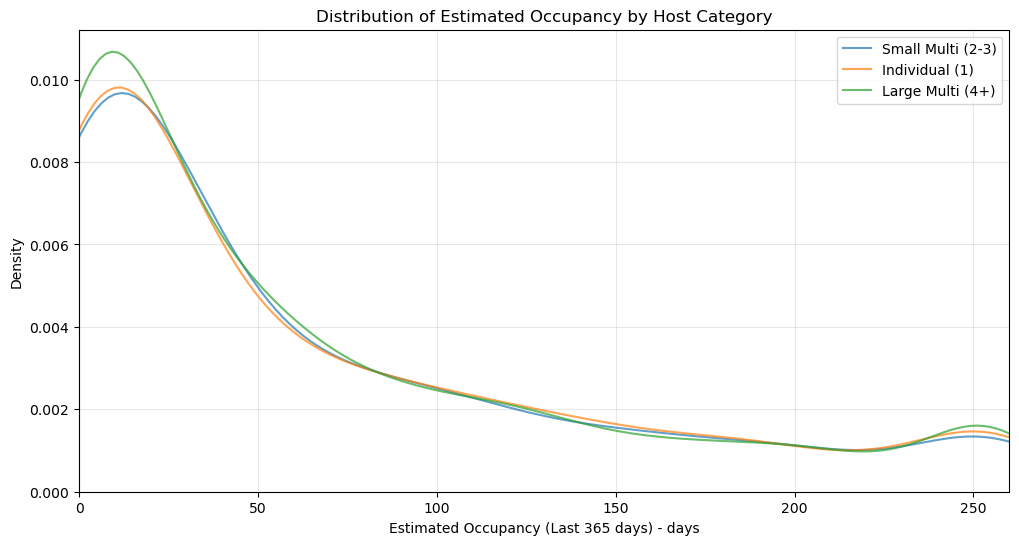

In [58]:
# Create density plot for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_occupancy_l365d'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Estimated Occupancy (Last 365 days) - days')
plt.ylabel('Density')
plt.title('Distribution of Estimated Occupancy by Host Category')
plt.xlim(0, 260)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


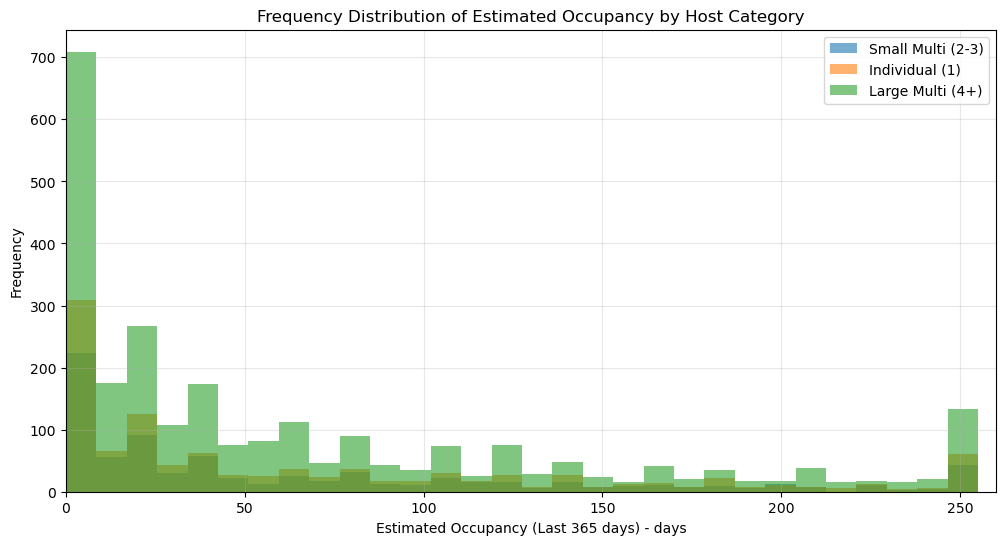

In [59]:
# Create frequency histograms for estimated_occupancy_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_occupancy_l365d'].dropna()
    plt.hist(data, bins=30, alpha=0.6, label=category, density=False)

plt.xlabel('Estimated Occupancy (Last 365 days) - days')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Estimated Occupancy by Host Category')
plt.xlim(0, 260)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [61]:
df[["estimated_occupancy_l365d", "estimated_revenue_l365d", "price"]].corr()

,estimated_occupancy_l365d,estimated_revenue_l365d,price
estimated_occupancy_l365d,1.000000,0.740199,-0.110070
estimated_revenue_l365d,0.740199,1.000000,0.241321
price,-0.110070,0.241321,1.000000


* nothing importand to note here, all categories show the same characteristics

### 3 - Reviews per month

In [62]:
df["reviews_per_month"].describe()

count    3950.000000
mean        1.461003
std         1.357813
min         0.010000
25%         0.460000
50%         1.050000
75%         2.040000
max        15.000000
Name: reviews_per_month, dtype: float64

In [63]:
df["reviews_per_month"].isnull().sum()

np.int64(499)

In [67]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["reviews_per_month"].mean()
    print(f"  Average Reviews per Month: {mean:.2f} reviews")

Host Category: Small Multi (2-3)
  Average Reviews per Month: 1.39 reviews
Host Category: Individual (1)
  Average Reviews per Month: 1.48 reviews
Host Category: Large Multi (4+)
  Average Reviews per Month: 1.48 reviews


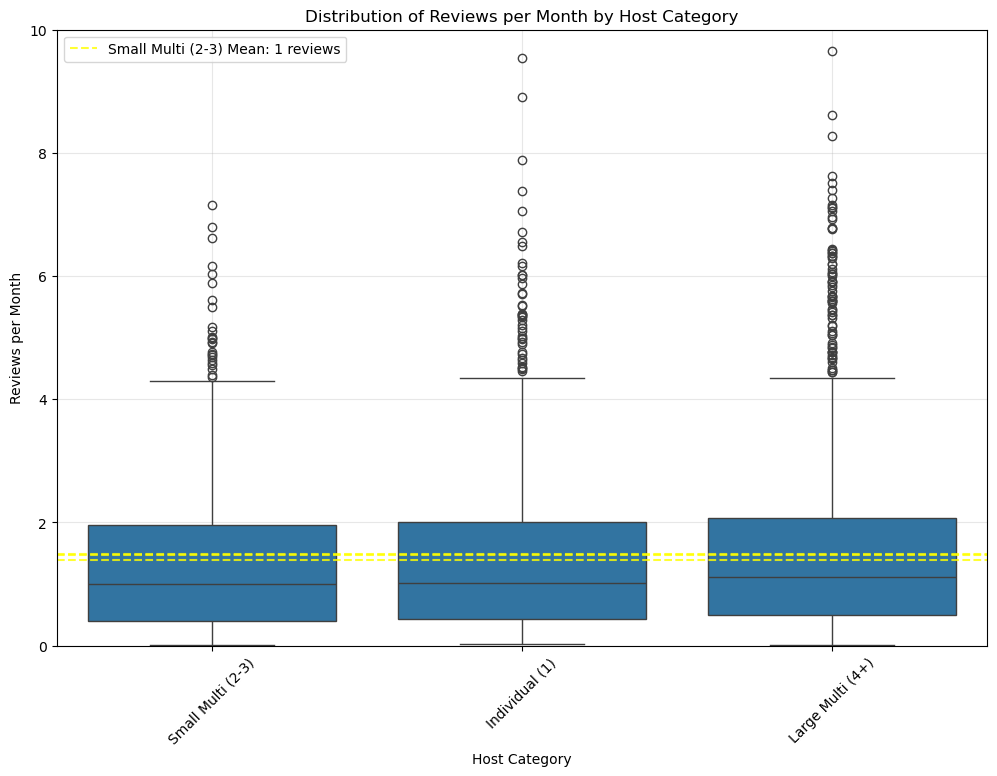

In [71]:

# Create boxplots for reviews_per_month by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='reviews_per_month')
plt.xlabel('Host Category')
plt.ylabel('Reviews per Month')
plt.title('Distribution of Reviews per Month by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['reviews_per_month'].mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} reviews' if i == 0 else "")
plt.ylim(0, 10)
plt.legend()
plt.show()

### 4 - Reviews ratings

In [ ]:
df["review_scores_rating"].isnull().sum()

np.int64(499)

In [76]:
df["review_scores_rating"].dropna().describe()

count    3950.000000
mean        4.730008
std         0.395369
min         1.000000
25%         4.670000
50%         4.850000
75%         4.970000
max         5.000000
Name: review_scores_rating, dtype: float64

In [75]:
df.loc[df["review_scores_rating"].isnull()]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
178,17755730,Business Flat Stavroupoli,117477639,2017-02-21,None,1.00,False,3,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00002499140,False,NaN,Small Multi (2-3)
198,18959007,Fabulous house in Panorama Thessaloniki,12928977,2014-03-08,"Thessaloniki, Greece",NaN,False,3,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00000040661,True,NaN,Small Multi (2-3)
466,28510642,Σοφίτα Σε Thessaloniki,215190004,2018-09-13,"Thessaloniki, Greece",NaN,False,3,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00000508636,True,NaN,Small Multi (2-3)
933,42482026,halu! Upscale Contemporary City Centre Penthouse,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00001124618,False,NaN,Large Multi (4+)
985,44175363,Thessaloniki - Quiet Loft Apartment in the City,154443586,2017-10-13,"Thessaloniki, Greece",1.00,False,2,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00001030930,False,NaN,Small Multi (2-3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446,1446980591343247146,White Lotus #Skgbnb,1977386,2012-03-20,"Thessaloniki, Greece",1.00,True,104,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003412164,True,NaN,Large Multi (4+)
4447,1447017899210584543,F & B Collection - Flat for 3,31131449,2015-04-13,"Thessaloniki, Greece",NaN,False,93,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003258473,True,NaN,Large Multi (4+)
4448,1447723147900850232,villa 8 studio delux,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003392735,True,NaN,Large Multi (4+)
4449,1447752389031362434,Ανακαινισμένο με δροσερή αυλή!,702402710,2025-06-20,None,1.00,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003305500,False,NaN,Individual (1)


In [77]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["review_scores_rating"].dropna().mean()
    print(f"  Average Review Scores Rating: {mean:.2f} stars")

Host Category: Small Multi (2-3)
  Average Review Scores Rating: 4.81 stars
Host Category: Individual (1)
  Average Review Scores Rating: 4.84 stars
Host Category: Large Multi (4+)
  Average Review Scores Rating: 4.66 stars


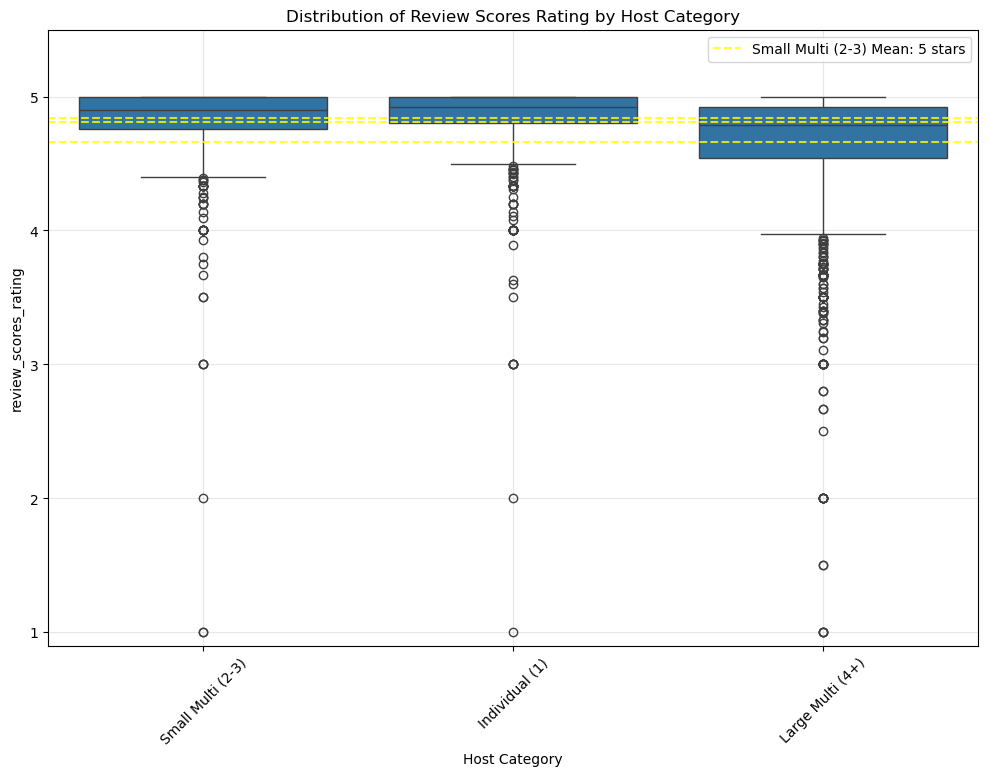

In [81]:
# Create boxplots for review_scores_rating by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='review_scores_rating')
plt.xlabel('Host Category')
plt.ylabel('review_scores_rating')
plt.title('Distribution of Review Scores Rating by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['review_scores_rating'].dropna().mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} stars' if i == 0 else "")
plt.ylim(0.9, 5.5)
plt.legend()
plt.show()

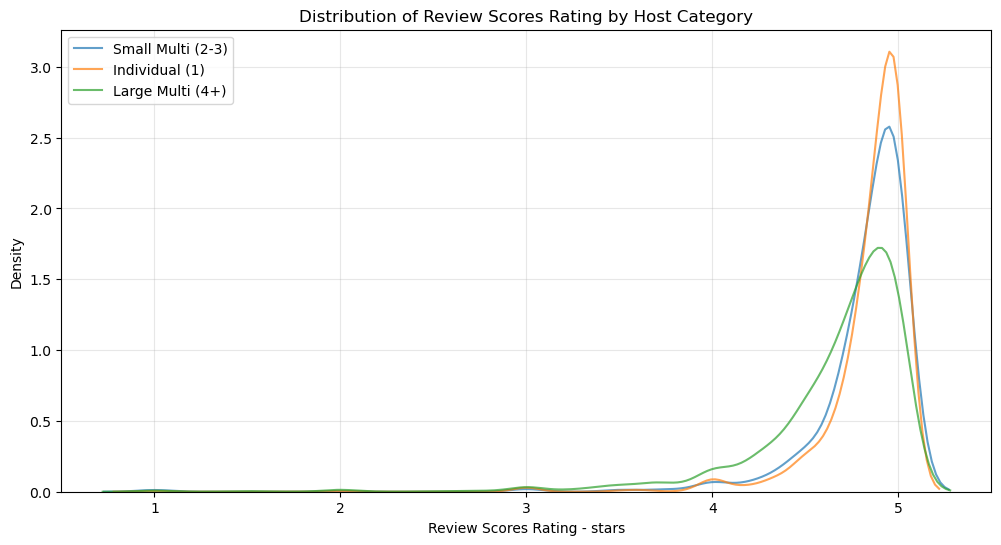

In [82]:
# Create density plot for review_scores_rating by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['review_scores_rating'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Review Scores Rating - stars')
plt.ylabel('Density')
plt.title('Distribution of Review Scores Rating by Host Category')
plt.xlim(0.5, 5.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**comments:**
* individual scores seem more confident and concentrated on higher vales, whereas 4+ category seems to exhibit a mean value lower than the overall average 

### 5 - Acceptance rate

In [83]:
df["host_acceptance_rate"].isnull().sum()

np.int64(486)

In [84]:
df["host_acceptance_rate"].describe()

count    3963.000000
mean        0.941148
std         0.178714
min         0.000000
25%         0.990000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_acceptance_rate, dtype: float64

In [89]:
df.loc[df["host_acceptance_rate"]==0]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.0,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.0,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
13,2639807,Apollon - Central apartment,13516901,2014-03-25,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.92,4.88,4.90,4.9,4.65,4.72,00000161920,False,0.79,Individual (1)
32,6408408,EVANGELIA: Only Good News Here...,33423743,2015-05-15,"Thessaloniki, Greece",0.0,False,3,True,"Thessaloníki, Greece",...,4.85,4.74,4.89,5.0,4.88,4.80,00000378638,False,0.54,Small Multi (2-3)
77,11651643,City center elegant loft,36326447,2015-06-21,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,4.97,5.00,5.0,5.00,4.95,00000209181,False,0.62,Small Multi (2-3)
100,12839242,Million dollars view,70104544,2016-05-03,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Makedonia Thraki, Greece",...,4.88,4.71,4.96,4.9,4.77,4.93,00000144789,False,1.20,Individual (1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,1378064487237445599,Άνετο διαμέρισμα με ένα δωμάτιο.,318973561,2019-12-19,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003251136,False,NaN,Individual (1)
4134,1379728058017266732,Δωμάτιο Θεσσαλονίκη,682925599,2025-03-07,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14919365701,False,NaN,Individual (1)
4319,1420470401996555460,Four Suns Loft,14852638,2014-04-28,"Skopje, North Macedonia",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003312231,False,NaN,Individual (1)
4346,1425082103671191566,il Panorama,563383717,2024-02-22,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003207999,False,NaN,Individual (1)


In [92]:
zero_acceptance = df[df['host_acceptance_rate'] == 0]

print("Average availability:", 
      zero_acceptance['availability_365'].mean())
print("Average revenue estimates:", 
      zero_acceptance['estimated_revenue_l365d'].mean())

Average availability: 219.28125
Average revenue estimates: 10.714285714285714


In [96]:
inactive_listings = df.loc[(df["host_acceptance_rate"]==0) & 
                           (df["estimated_occupancy_l365d"]==0) & 
                           (df["number_of_reviews_ly"]==0)]
inactive_listings

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.0,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.00,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
13,2639807,Apollon - Central apartment,13516901,2014-03-25,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.92,4.88,4.90,4.90,4.65,4.72,00000161920,False,0.79,Individual (1)
32,6408408,EVANGELIA: Only Good News Here...,33423743,2015-05-15,"Thessaloniki, Greece",0.0,False,3,True,"Thessaloníki, Greece",...,4.85,4.74,4.89,5.00,4.88,4.80,00000378638,False,0.54,Small Multi (2-3)
77,11651643,City center elegant loft,36326447,2015-06-21,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,4.97,5.00,5.00,5.00,4.95,00000209181,False,0.62,Small Multi (2-3)
100,12839242,Million dollars view,70104544,2016-05-03,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Makedonia Thraki, Greece",...,4.88,4.71,4.96,4.90,4.77,4.93,00000144789,False,1.20,Individual (1)
105,13311881,"Penthouse apartment with view, close to the ce...",75230884,2016-06-01,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,4.88,4.87,4.96,4.98,4.66,4.83,00000337588,False,2.80,Small Multi (2-3)
240,20768326,Pretty flat at the city of Thessaloniki,148785081,2017-09-02,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.63,4.44,4.75,4.63,4.25,4.31,00001646333,False,0.44,Individual (1)
356,24283295,Λειτουργικό διαμερισμα,183161769,2018-04-08,Greece,0.0,False,1,True,"Eleftherio Kordelio, Greece",...,5.00,5.00,5.00,5.00,5.00,5.00,00000839067,False,0.02,Individual (1)
369,24612348,Aristoteles Square Apartment,114781155,2017-02-04,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,5.00,5.00,5.00,5.00,5.00,00002257456,False,0.01,Small Multi (2-3)
440,27887898,Elena's hope - home,210672602,2018-08-20,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Greece",...,5.00,4.80,5.00,5.00,5.00,5.00,00000378751,False,0.06,Individual (1)


the above listings seem to be somehow inactive and will be removed for the analysis of the current variable

In [100]:
df_active = df.drop(index=inactive_listings.index)
for category in df_active["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df_active.loc[df_active['host_category'] == category]["host_acceptance_rate"].mean()
    print(f"  Average Host Acceptance Rate: {mean:.2f}")

Host Category: Individual (1)
  Average Host Acceptance Rate: 0.94
Host Category: Large Multi (4+)
  Average Host Acceptance Rate: 0.97
Host Category: Small Multi (2-3)
  Average Host Acceptance Rate: 0.93


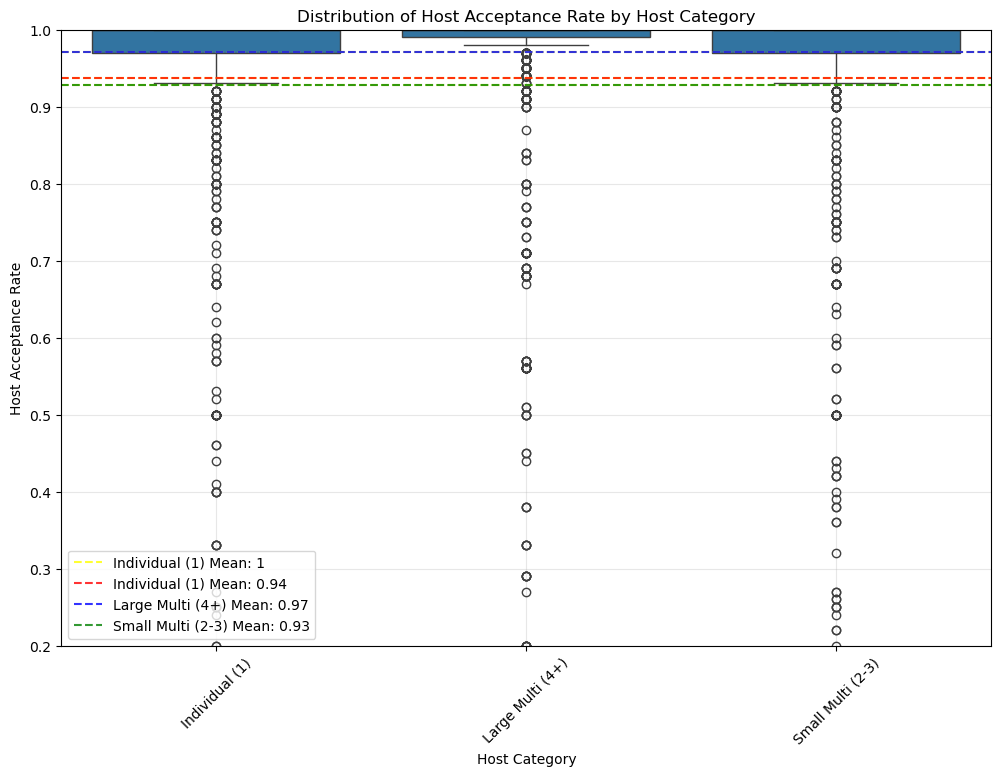

In [103]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_active, x='host_category', y='host_acceptance_rate')
plt.xlabel('Host Category')
plt.ylabel('Host Acceptance Rate')
plt.title('Distribution of Host Acceptance Rate by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df_active["host_category"].unique()):
    mean_val = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna().mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} ' if i == 0 else "")
colors = ['red', 'blue', 'green']
for i, category in enumerate(df_active["host_category"].unique()):
    mean_val = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna().mean()
    plt.axhline(y=mean_val, color=colors[i], linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.2f}')
plt.ylim(0.2, 1)
plt.legend()
plt.show()

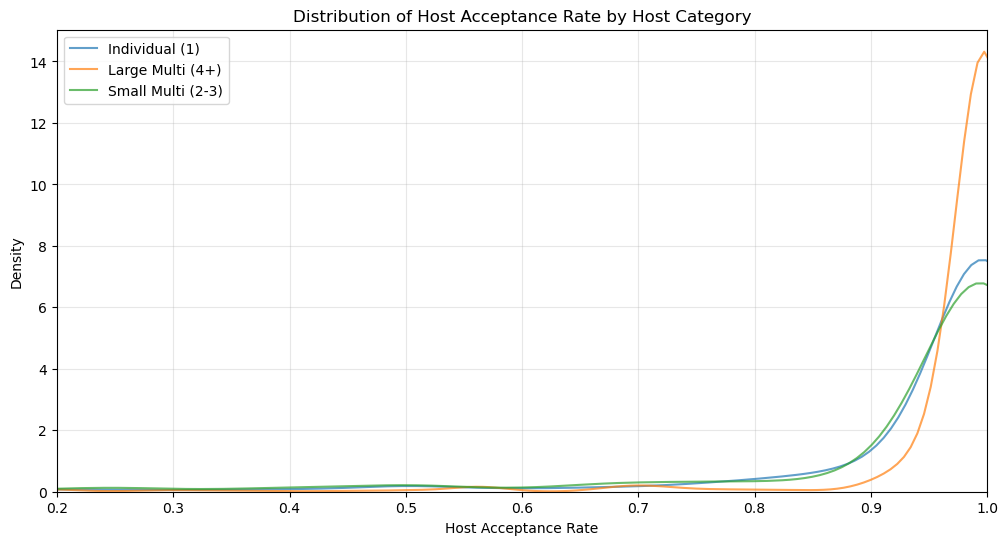

In [104]:
# Create density plot for review_scores_rating by host_category
plt.figure(figsize=(12, 6))
for category in df_active["host_category"].unique():
    data = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Host Acceptance Rate')
plt.ylabel('Density')
plt.title('Distribution of Host Acceptance Rate by Host Category')
plt.xlim(0.2, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**comment**
* multi hosts seem to be more willing to accept customers showing a more professional approach

### 7 - Superhost percentage

In [32]:
df["host_is_superhost"].isnull().sum()

np.int64(340)

In [ ]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    print(df.loc[df['host_category'] == category]["host_is_superhost"].dropna().value_counts(normalize=True))
    print(df.loc[df['host_category'] == category]["host_is_superhost"].isnull().sum())


Host Category: Small Multi (2-3)
host_is_superhost
False    0.570681
True     0.429319
Name: proportion, dtype: float64
29
Host Category: Individual (1)
host_is_superhost
False    0.658627
True     0.341373
Name: proportion, dtype: float64
0
Host Category: Large Multi (4+)
host_is_superhost
False    0.633877
True     0.366123
Name: proportion, dtype: float64
311


**comment:**
* surprisingly the 2-3 category has the most superhosts (maybe a sign of hosts that want to put more effort in growing their rental business?)
* individuals have the lowest rate of superhosts but not far away from multihosts

### 8 - Availability 365

In [107]:
df["availability_365"].isnull().sum()

np.int64(0)

In [109]:
no_availability = df.loc[df["availability_365"]==0]
no_availability

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.00,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.00,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
12,2525130,Luxurious fabulous modern studio - Panorama ce...,12928977,2014-03-08,"Thessaloniki, Greece",NaN,False,3,True,"Panorama, Makedonia Thraki, Greece",...,4.00,4.00,5.00,5.00,5.00,4.00,00000040650,True,0.05,Small Multi (2-3)
37,6773050,Penthouse in the City Centre !!,25211962,2014-12-26,"Thessaloniki, Greece",1.00,True,2,True,"Thessaloníki, Greece",...,4.78,4.87,4.96,4.96,4.88,4.83,00003249285,True,0.69,Small Multi (2-3)
55,8610663,5* LOFT PILAIA -splendid view 360*,35478692,2015-06-10,"Makedonia Thraki, Greece",1.00,False,1,True,NaN,...,4.71,4.92,4.89,4.87,4.85,4.72,00000162447,True,0.43,Individual (1)
64,10483750,CITY CENTRAL 1 BEDROOM FLAT,54039142,2016-01-10,"Thessaloniki, Greece",NaN,False,1,True,NaN,...,4.75,4.79,4.86,4.82,4.86,4.64,00000157608,False,0.24,Individual (1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,1333135394319175698,Studio Apartment 35,599770135,2024-09-03,None,1.00,False,45,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003176645,True,NaN,Large Multi (4+)
3925,1338584833249174711,Cozy apartment centrally located,45358495,2015-09-29,"Athens, Greece",0.00,False,2,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003042921,False,NaN,Small Multi (2-3)
3958,1344913730539549246,Thessaloniki city center Apartment,110611523,2017-01-09,Greece,0.83,False,11,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003196616,True,NaN,Large Multi (4+)
4104,1373769925563050106,Amelie by halu! 2-BD modern apt,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003243519,True,NaN,Large Multi (4+)


159 listings with zero availability data. maybe a systematic error, faulty listings or inactive ones. they will be removed for validation purposes

In [110]:
df_available = df.drop(index=no_availability.index)
df_available.shape

(4290, 43)

In [113]:
df_available[["availability_30", "availability_90", "availability_365"]].describe()

,availability_30,availability_90,availability_365
count,4290.00000,4290.000000,4290.000000
mean,17.20303,61.189744,243.851515
std,9.71926,25.481246,106.372674
min,0.00000,0.000000,1.000000
25%,9.00000,46.000000,162.000000
50%,19.00000,68.000000,266.000000
75%,26.00000,83.000000,343.000000
max,30.00000,90.000000,365.000000


In [117]:
for category in df_available["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df_available.loc[df_available['host_category'] == category][["availability_30", "availability_90", "availability_365"]].dropna().mean()
    print(f"  Average Availability (days)")
    print(mean.round(2), "\n")

Host Category: Individual (1)
  Average Availability (days)
availability_30      15.32
availability_90      55.17
availability_365    226.43
dtype: float64 

Host Category: Large Multi (4+)
  Average Availability (days)
availability_30      18.42
availability_90      65.19
availability_365    256.59
dtype: float64 

Host Category: Small Multi (2-3)
  Average Availability (days)
availability_30      15.73
availability_90      56.20
availability_365    225.55
dtype: float64 



**comment**
* small multi and invidual listing host show similar availability patterns
* large multi seem to have more days of availability on average which indicates larger particiapation in the market

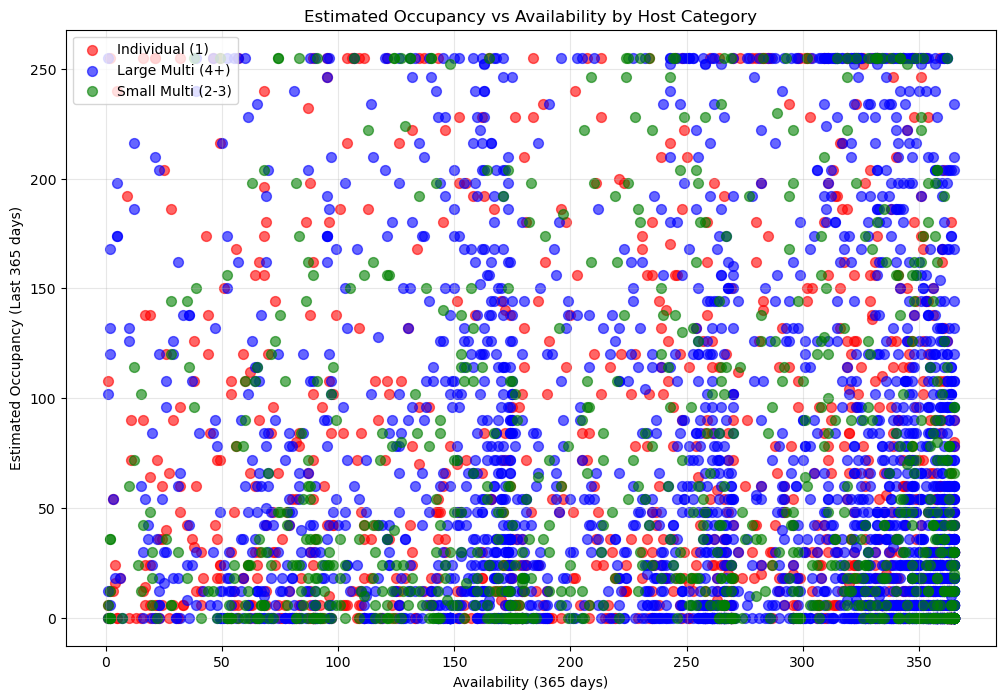

In [118]:
plt.figure(figsize=(12, 8))

# Create scatter plot with different colors for each host category
colors = ['red', 'blue', 'green']
for i, category in enumerate(df_available["host_category"].unique()):
    category_data = df_available[df_available['host_category'] == category]
    plt.scatter(category_data['availability_365'], category_data['estimated_occupancy_l365d'], 
                c=colors[i], alpha=0.6, label=category, s=50)

plt.xlabel('Availability (365 days)')
plt.ylabel('Estimated Occupancy (Last 365 days)')
plt.title('Estimated Occupancy vs Availability by Host Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

correlation analysis

In [7]:
# Correlation analysis by host category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['host_category'] == category]
    
    # Key correlations
    corr_matrix = cat_data[['host_acceptance_rate', 'review_scores_rating', 
                             'estimated_revenue_l365d', 'estimated_occupancy_l365d',
                             'availability_365']].corr()
    
    print(f"\n{category} Correlations:")
    print(corr_matrix)


Individual (1) Correlations:
                           host_acceptance_rate  review_scores_rating  \
host_acceptance_rate                   1.000000              0.128554   
review_scores_rating                   0.128554              1.000000   
estimated_revenue_l365d                0.236538              0.142796   
estimated_occupancy_l365d              0.261697              0.126574   
availability_365                      -0.004002             -0.044351   

                           estimated_revenue_l365d  estimated_occupancy_l365d  \
host_acceptance_rate                      0.236538                   0.261697   
review_scores_rating                      0.142796                   0.126574   
estimated_revenue_l365d                   1.000000                   0.862635   
estimated_occupancy_l365d                 0.862635                   1.000000   
availability_365                         -0.002381                   0.042462   

                           availability_365 

In [14]:
# Compare superhosts vs non-superhosts within each category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['host_category'] == category]
    
    superhosts = cat_data[cat_data['host_is_superhost'] == True]
    non_superhosts = cat_data[cat_data['host_is_superhost'] == False]
    
    print(f"\n{category}:")
    print(f"Superhost avg revenue: {superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Non-superhost avg revenue: {non_superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Superhost avg rating: {superhosts['review_scores_rating'].mean():.2f}")
    print(f"Non-superhost avg rating: {non_superhosts['review_scores_rating'].mean():.2f}")


Individual (1):
Superhost avg revenue: 7704.46
Non-superhost avg revenue: 2002.82
Superhost avg rating: 4.91
Non-superhost avg rating: 4.79

Small Multi (2-3):
Superhost avg revenue: 6661.96
Non-superhost avg revenue: 1770.95
Superhost avg rating: 4.90
Non-superhost avg rating: 4.74

Large Multi (4+):
Superhost avg revenue: 5214.93
Non-superhost avg revenue: 2997.85
Superhost avg rating: 4.85
Non-superhost avg rating: 4.52


### statistical testing for base hypotheses

In [14]:
from scipy import stats
from scipy.stats import chi2_contingency

#### 1 - Revenue difference across groups and superhost status

In [23]:
print("="*60)
print("TEST 1: REVENUE DIFFERENCES ACROSS HOST CATEGORIES")
print("="*60)

individual = df[df['host_category'] == 'Individual (1)']['estimated_revenue_l365d'].dropna()
small_multi = df[df['host_category'] == 'Small Multi (2-3)']['estimated_revenue_l365d'].dropna()
large_multi = df[df['host_category'] == 'Large Multi (4+)']['estimated_revenue_l365d'].dropna()

print(f"Individual: n={len(individual)}, mean=€{individual.mean():.2f}, median=€{individual.median():.2f}")
print(f"Small Multi: n={len(small_multi)}, mean=€{small_multi.mean():.2f}, median=€{small_multi.median():.2f}")
print(f"Large Multi: n={len(large_multi)}, mean=€{large_multi.mean():.2f}, median=€{large_multi.median():.2f}")

f_stat, p_value = stats.f_oneway(individual, small_multi, large_multi)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")

TEST 1: REVENUE DIFFERENCES ACROSS HOST CATEGORIES
Individual: n=997, mean=€4010.12, median=€2112.00
Small Multi: n=747, mean=€3971.27, median=€1836.00
Large Multi: n=2429, mean=€4002.81, median=€1980.00

ANOVA Results: F=0.011, p-value=0.9890
Significant at α=0.05: False


In [25]:
groups = []
group_names = []

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    for is_super in [True, False]:
        group_data = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == is_super)]['estimated_revenue_l365d'].dropna()
        groups.append(group_data)
        status = "Superhost" if is_super else "Non-SH"
        group_names.append(f"{category} {status}")
        print(f"{category} {status}: n={len(group_data)}, mean=€{group_data.mean():.2f}")

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")

Individual (1) Superhost: n=351, mean=€7704.46
Individual (1) Non-SH: n=646, mean=€2002.82
Small Multi (2-3) Superhost: n=313, mean=€6661.96
Small Multi (2-3) Non-SH: n=406, mean=€1770.95
Large Multi (4+) Superhost: n=791, mean=€5214.93
Large Multi (4+) Non-SH: n=1353, mean=€2997.85

ANOVA Results: F=95.783, p-value=0.0000
Significant at α=0.05: True


#### 2 - Superhost revenue multiplier

In [20]:
print("\n" + "="*60)
print("TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)")
print("="*60)

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['host_category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts)
    
    revenue_diff = superhosts.mean() - non_superhosts.mean()
    multiplier = superhosts.mean() / non_superhosts.mean() if non_superhosts.mean() > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Revenue difference: €{revenue_diff:.2f} ({multiplier:.2f}x)")
    print(f"  t={t_stat:.3f}, p={p_value:.4f}, Significant: {p_value < 0.05}")


TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)

Individual (1):
  Revenue difference: €5701.63 (3.85x)
  t=20.996, p=0.0000, Significant: True

Small Multi (2-3):
  Revenue difference: €4891.01 (3.76x)
  t=12.428, p=0.0000, Significant: True

Large Multi (4+):
  Revenue difference: €2217.08 (1.74x)
  t=8.253, p=0.0000, Significant: True


#### 4 - Review score diffences accross categories

In [21]:
print("\n" + "="*60)
print("TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES")
print("="*60)

rating_groups = []
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    ratings = df[df['host_category'] == category]['review_scores_rating'].dropna()
    rating_groups.append(ratings)
    print(f"{category}: mean={ratings.mean():.3f}, std={ratings.std():.3f}, n={len(ratings)}")

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES
Individual (1): mean=4.838, std=0.289, n=964
Small Multi (2-3): mean=4.812, std=0.337, n=727
Large Multi (4+): mean=4.658, std=0.435, n=2259

ANOVA Results: F=93.424, p-value=0.0000
Significant at α=0.05: True


#### superhost rate differences

In [22]:
print("\n" + "="*60)
print("TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)")
print("="*60)

# Create contingency table
contingency_table = pd.crosstab(df['host_category'], df['host_is_superhost'])
print("\nContingency Table:")
print(contingency_table)

# Calculate percentages
superhost_rates = df.groupby('host_category')['host_is_superhost'].apply(
    lambda x: (x == True).sum() / len(x) * 100
)
print("\nSuperhost Rates:")
for category in superhost_rates.index:
    print(f"{category}: {superhost_rates[category]:.2f}%")

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Results: χ²={chi2:.3f}, p-value={p_value:.4f}, df={dof}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)

Contingency Table:
host_is_superhost  False  True 
host_category                  
Individual (1)       710    368
Large Multi (4+)    1437    830
Small Multi (2-3)    436    328

Superhost Rates:
Individual (1): 34.14%
Large Multi (4+): 32.20%
Small Multi (2-3): 41.36%

Chi-square Results: χ²=15.412, p-value=0.0005, df=2
Significant at α=0.05: True


In [27]:
# Verify the 7K-15K segment composition
premium_segment = df[(df['estimated_revenue_l365d'] >= 7000) & 
                     (df['estimated_revenue_l365d'] <= 15000)]

print("="*60)
print("PREMIUM SEGMENT (€7K-15K) COMPOSITION")
print("="*60)

segment_composition = premium_segment['host_category'].value_counts()
segment_percentages = premium_segment['host_category'].value_counts(normalize=True) * 100

print("\nAbsolute counts:")
print(segment_composition)
print("\nPercentages:")
print(segment_percentages)

# Compare to overall market share
print("\n--- Comparison to overall market share ---")
overall_composition = df['host_category'].value_counts(normalize=True) * 100
comparison = pd.DataFrame({
    'Premium Segment %': segment_percentages,
    'Overall Market %': overall_composition,
    'Difference': segment_percentages - overall_composition
})
print(comparison)

PREMIUM SEGMENT (€7K-15K) COMPOSITION

Absolute counts:
host_category
Large Multi (4+)     365
Individual (1)       191
Small Multi (2-3)    118
Name: count, dtype: int64

Percentages:
host_category
Large Multi (4+)     54.154303
Individual (1)       28.338279
Small Multi (2-3)    17.507418
Name: proportion, dtype: float64

--- Comparison to overall market share ---
                   Premium Segment %  Overall Market %  Difference
host_category                                                     
Large Multi (4+)           54.154303         57.945606   -3.791303
Individual (1)             28.338279         24.230164    4.108115
Small Multi (2-3)          17.507418         17.824230   -0.316812


#### effect size - should tests be trusted?

In [29]:

print("\n" + "="*60)
print("EFFECT SIZES (Cohen's d for revenue differences)")
print("="*60)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['host_category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    if len(superhosts) > 0 and len(non_superhosts) > 0:
        d = cohens_d(superhosts, non_superhosts)
        interpretation = "small" if abs(d) < 0.5 else "medium" if abs(d) < 0.8 else "large"
        print(f"{category}: d={d:.3f} ({interpretation} effect)")


EFFECT SIZES (Cohen's d for revenue differences)
Individual (1): d=1.392 (large effect)
Small Multi (2-3): d=0.935 (large effect)
Large Multi (4+): d=0.369 (small effect)


In [31]:
print("="*60)
print("TEST: REVENUE DIFFERENCES WITHIN €7K-15K PREMIUM SEGMENT")
print("="*60)

# Filter to premium segment
premium = df[(df['estimated_revenue_l365d'] >= 7000) & 
             (df['estimated_revenue_l365d'] <= 15000)]

# Split by host category
prem_individual = premium[premium['host_category'] == 'Individual (1)']['estimated_revenue_l365d']
prem_small = premium[premium['host_category'] == 'Small Multi (2-3)']['estimated_revenue_l365d']
prem_large = premium[premium['host_category'] == 'Large Multi (4+)']['estimated_revenue_l365d']

print(f"Individual: n={len(prem_individual)}, mean=€{prem_individual.mean():.2f}")
print(f"Small Multi: n={len(prem_small)}, mean=€{prem_small.mean():.2f}")
print(f"Large Multi: n={len(prem_large)}, mean=€{prem_large.mean():.2f}")

# ANOVA
f_stat, p_value = stats.f_oneway(prem_individual, prem_small, prem_large)
print(f"\nANOVA: F={f_stat:.3f}, p={p_value:.4f}")
print(f"Significant: {p_value < 0.05}")

# Effect size (eta-squared)
grand_mean = premium['estimated_revenue_l365d'].mean()
ss_between = sum([len(g) * (g.mean() - grand_mean)**2 
                  for g in [prem_individual, prem_small, prem_large]])
ss_total = sum((premium['estimated_revenue_l365d'] - grand_mean)**2)
eta_squared = ss_between / ss_total
print(f"η² = {eta_squared:.3f} ({'small' if eta_squared < 0.06 else 'medium' if eta_squared < 0.14 else 'large'} effect)")

TEST: REVENUE DIFFERENCES WITHIN €7K-15K PREMIUM SEGMENT
Individual: n=191, mean=€10183.49
Small Multi: n=118, mean=€9923.97
Large Multi: n=365, mean=€9982.82

ANOVA: F=0.731, p=0.4819
Significant: False
η² = 0.002 (small effect)


In [ ]:
null_super_multi =df.loc[(df["host_category"] == "Large Multi (4+)") & (df["host_is_superhost"].isnull())]

In [37]:
null_super_multi["estimated_revenue_l365d"].describe()

count      285.000000
mean      5409.600000
std       5576.249613
min          0.000000
25%       1302.000000
50%       3720.000000
75%       7812.000000
max      29574.000000
Name: estimated_revenue_l365d, dtype: float64

In [38]:
null_super_multi

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
42,7710541,Tailor's Suites #1,40505568,2015-08-04,"Thessaloniki, Greece",1.00,None,4,True,NaN,...,4.79,4.94,4.81,4.81,4.58,4.71,00002470248,False,2.17,Large Multi (4+)
75,11462299,"Amazing view,downtown luxurious 2bd",16478745,2014-06-06,"Thessaloniki, Greece",1.00,None,9,True,"Thessaloniki, Greece",...,4.93,4.91,4.86,4.87,4.96,4.87,00003013990,False,3.30,Large Multi (4+)
133,14915461,Sweet Home!!,77882456,2016-06-15,"Thessaloniki, Greece",0.99,None,4,True,"Thessaloniki, Greece",...,4.81,4.76,4.91,4.95,4.61,4.75,00000573763,True,2.05,Large Multi (4+)
152,16115782,Navarinou sq.-ancient ruins view-lux 2BD apart...,16478745,2014-06-06,"Thessaloniki, Greece",1.00,None,9,True,"Thessaloniki, Greece",...,4.89,4.89,4.90,4.85,4.96,4.80,00000070690,False,3.41,Large Multi (4+)
156,16490221,Exotic Home Paradise!,77882456,2016-06-15,"Thessaloniki, Greece",0.99,None,4,True,"Thessaloniki, Greece",...,4.78,4.73,4.93,4.95,4.54,4.65,00000573730,True,2.58,Large Multi (4+)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423,1442537006567181244,FOS Apartments by halu! - Two-bedroom apartment,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390115,True,NaN,Large Multi (4+)
4424,1442622683587036364,FOS Apartments by halu! - Loft,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390183,True,NaN,Large Multi (4+)
4426,1442639548729538800,FOS Apartments by halu! - Studio,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390242,True,NaN,Large Multi (4+)
4432,1444789520590263542,Aristotle Three City View Apartment by BiNoBi!,548386310,2023-11-27,None,0.98,None,65,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003373719,True,NaN,Large Multi (4+)


t test for difffernce of means in price by category